# ***1. Introducción***
***
En este proyecto se toman datos de una base de datos de transacciones, con información geográfica, de montos, y de los clientes que realizan las transacciones, para determinar si la transacción es fraudulenta o no. 

Para lograr esto, se sigue el siguiente proceso:

1. Introducción
2. Validación y exploración de los datos

   2.1 Validación de los datos
   
   2.2 Análisis de datos
   
2. Preparación de los datos
3. Selección de modelo, mejora/ajuste del modelo
4. Presentación de resultados

Se selecciona como modelo una red neuronal profunda (DNN), que inicia como una red relativamente sencilla, y que en la parte de mejora y ajuste se vuelve tan compleja como sea necesario a través de comparaciones con *coss-validation*. 

In [52]:
# Import libraries and set plot styles and parameters:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import sklearn
import sys
import os
import datetime
from dateutil.relativedelta import relativedelta

# This two libraries could cause installation conflicts, be careful please:
import geopandas as gpd
import plotly.express as px


%load_ext autoreload
%autoreload 2

# My module
import utils_payu
mlp.style.use('seaborn')
sns.set(font_scale=1.2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ***2. Validación y exploración de datos***
***

En esta primera sección se importa la tabla de trabajo y se hace un análisis descriptivo de los datos. Inmediatamente se revisa si la proporción de datos faltantes por columna. Como se evidencia abajo, los datos parecen tener la información completa:

## *2.1 Validación de los datos*
En esta sección se importan y valida la calidad de los datos, revisando si hay presencia de valores faltantes, valores extraños o tipos diferentes a los esperados.

In [2]:
# Load and read properly the CSV file:
df = pd.read_csv('DatosPrueba.csv', delimiter=';', decimal=',')

# Give date type to date columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

print('NAN values per Column')
print('----------------------\n')
df.info()


NAN values per Column
----------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200881 entries, 0 to 200880
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             200881 non-null  int64         
 1   Unnamed: 0.1           200881 non-null  int64         
 2   trans_date_trans_time  200881 non-null  datetime64[ns]
 3   cc_num                 200881 non-null  int64         
 4   merchant               200881 non-null  object        
 5   category               200881 non-null  object        
 6   amt                    200881 non-null  float64       
 7   first                  200881 non-null  object        
 8   last                   200881 non-null  object        
 9   gender                 200881 non-null  object        
 10  street                 200881 non-null  object        
 11  city                   200881 non-null  object        
 12

Otra forma de validar que los datos no estén presentando fallas o errores es validando los *data types* de cada columna, donde problemas de formato llevarían a que el tipo se trunque a `object`. Abajo se observa que las columnas que se esperan que sean numéricas presentan un tipo diferente al esperado (*e.g.* `amt, lat, long`). Esto se corrige importando los datos con `,` como separador decimal durante el cargue de la base. Con esto hecho ya se ve que los datos tienen los tipos esperados.


Para finalizar esta validación de información se evalúan valores extremos y comportamiento general de los datos.

In [3]:
df.select_dtypes(include=[int, float, np.float64, np.int64]).agg(
    [min, max, np.std, 'mean']
)

,Unnamed: 0,Unnamed: 0.1,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
min,3.000000e+00,3.000000e+00,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.033288,-166.671242,0.000000
max,1.296674e+06,1.296674e+06,4.992346e+18,14467.640000,99783.000000,66.693300,-67.950300,2.906700e+06,1.371817e+09,67.510267,-66.958751,1.000000
std,3.753200e+05,3.753200e+05,1.306632e+18,180.409147,26914.330746,5.090472,13.794411,3.019086e+05,1.287819e+07,5.124502,13.805559,0.189656
mean,6.486983e+05,6.486983e+05,4.156141e+17,85.128618,48826.911331,38.545014,-90.242478,8.920038e+04,1.349255e+09,38.545281,-90.241478,0.037365


Como se puede ver en la tabla de arriba, se puede ver que los valores que presentan las columnas están dentro de los rangos esperados para este tipo de variables. Abajo se presentan unas estadísticas descriptivas más detalladas. **Otro factor importante de la tabla abajo es que se está trabajando con un número no pequeño de transacciones, por lo que técnicas de rebalanceo pueden ser muy viables durante la etapa de procesado de datos.**

In [4]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,2.008810e+05,2.008810e+05,2.008810e+05,200881.000000,200881.000000,200881.000000,200881.000000,2.008810e+05,2.008810e+05,200881.000000,200881.000000,200881.000000
mean,6.486983e+05,6.486983e+05,4.156141e+17,85.128618,48826.911331,38.545014,-90.242478,8.920038e+04,1.349255e+09,38.545281,-90.241478,0.037365
std,3.753200e+05,3.753200e+05,1.306632e+18,180.409147,26914.330746,5.090472,13.794411,3.019086e+05,1.287819e+07,5.124502,13.805559,0.189656
min,3.000000e+00,3.000000e+00,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.033288,-166.671242,0.000000
25%,3.227590e+05,3.227590e+05,1.800429e+14,9.840000,26237.000000,34.668900,-96.809400,7.430000e+02,1.338724e+09,34.751817,-96.926922,0.000000
50%,6.494780e+05,6.494780e+05,3.521417e+15,48.860000,48174.000000,39.354300,-87.476900,2.456000e+03,1.349299e+09,39.352830,-87.453214,0.000000
75%,9.756200e+05,9.756200e+05,4.642255e+15,86.650000,72042.000000,41.948800,-80.175200,2.032800e+04,1.359589e+09,41.964456,-80.249053,0.000000
max,1.296674e+06,1.296674e+06,4.992346e+18,14467.640000,99783.000000,66.693300,-67.950300,2.906700e+06,1.371817e+09,67.510267,-66.958751,1.000000


## *2.2 Análisis de datos*
En esta sección se hace un análisis visual y estadístico de variables que pueden ser de interés para la etapa de modelación. 

En el gráfico abajo se presenta el número de casos analizados (segmentados en *Fraude* para los valores 1 en la columna `is_fraud`, y *No fraude* para los 0s). De entrada es evidente que estamos trabajando con una tabla con datos desbalanceados para la variable objetivo, lo cual se ilustran tanto a nivel de conteo de casos como a nivel porcentual:

Figure category_fraud saved!


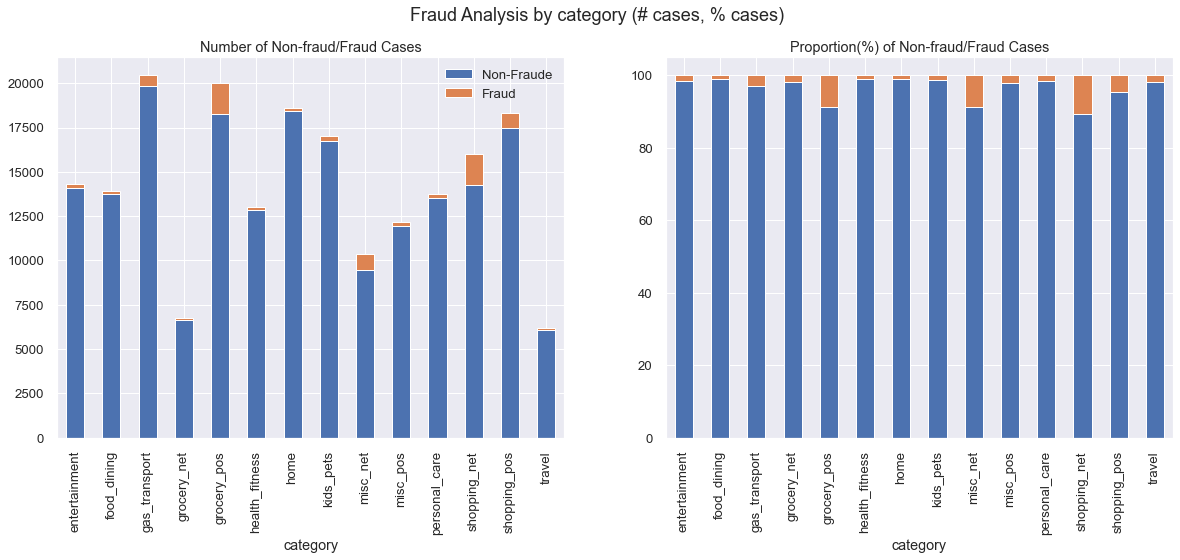

In [5]:
fig, ax = utils_payu.categorical_plot(df, 'category', figsize=(20,7))
utils_payu.save_plot('category_fraud')

Algo que cabe resaltar de esta variable categórica es que no tiene un número muy alto de categorías (lo cual podría hace que una transformación *one-hot encoding* quede con muchos 0s), además de presentar variabilidad en cuanto a la proporción de casos de fraude, por lo que promete ser una variable útil para el modelo. 

Otra variable a analizar puede ser género. Sin embargo vale la pena mencionar que debido a regulaciones/reglas esta variable puede no ser válida como input para modelos debido a posibles sesgos negativos que pueda generar. Abajo se puede observar que la proporción de transacciones fraudulentas de mujeres es un poco menor. Esta variable por lo tanto también introduce variabilidad, por lo cual puede agregar valor al modelo.

Figure gender_fraud saved!


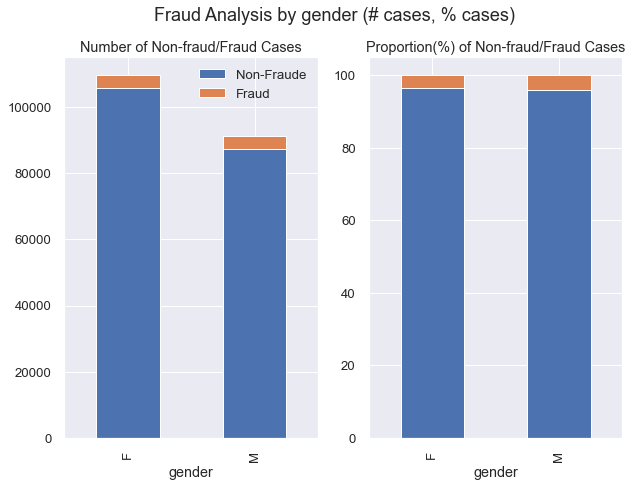

In [6]:
# Gender analysis:
fig, ax = utils_payu.categorical_plot(df, 'gender', figsize=(10,7))
utils_payu.save_plot('gender_fraud')

Al hacer el análisis por estado se evidencia una mayor variabilidad en esta variable categórica. Esto indica que esta variable categórica, transformada con *one-hot encoding* puede ser útil también para el modeloÑ

Figure state_fraud saved!


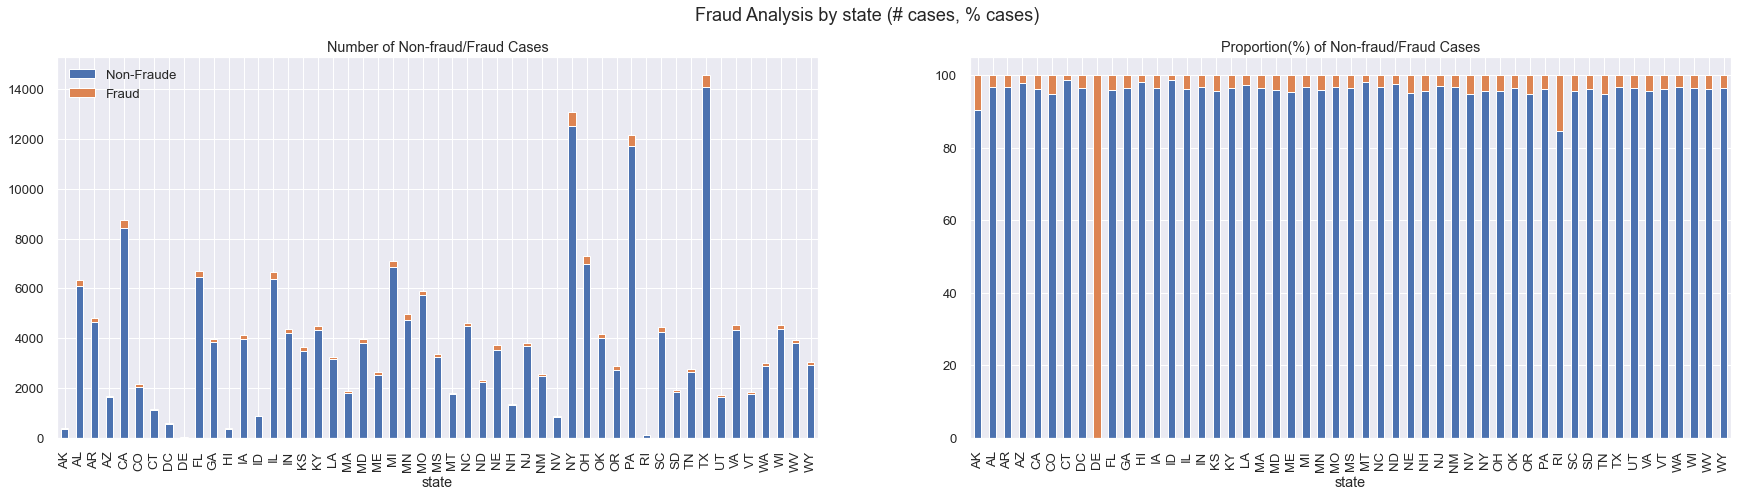

In [7]:
# State analysis:
fig, ax = utils_payu.categorical_plot(df, 'state', figsize=(30,7))
utils_payu.save_plot('state_fraud')

Dado que se tiene la fecha de nacimiento, se crea una variable adicional: `age` que es igual al numero de años de cada persona (medida a partir de años de 365 días):

In [8]:
df['age'] = (datetime.datetime.now()-df['dob']).dt.days/365

Finalmente, se hace una visualización de las distribuciones de las variables continuas de interés. Como se puede ver, tanto el monto de las transacciones `amt` como la población de la ciudad `city_pop` tienen una distribución muy sesgada, por lo que puede considerarse utilizar transformaciones logarítmicas en para los modelos, de forma que se transforme la distribución a algo más similar a la normal:

$$\text{Var. Transformada} =  -\log{\left(1-\frac{1}{var}\right)}$$

Figure cont_vars_dist saved!


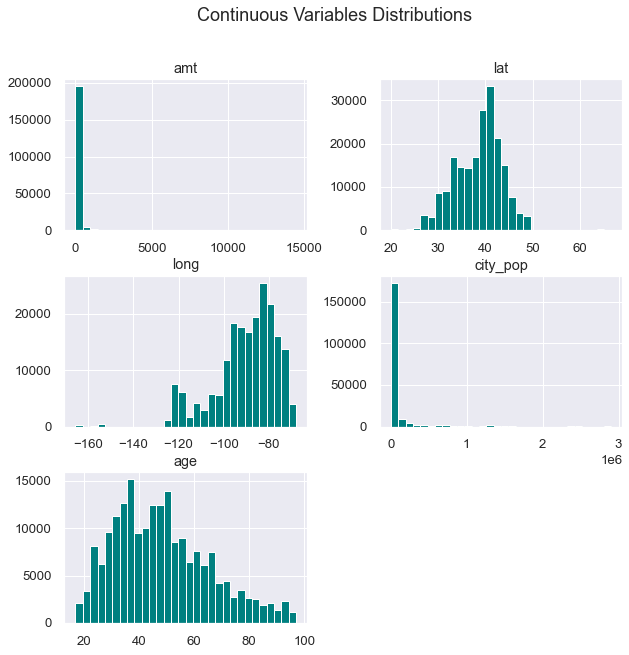

In [9]:
cont_vars = ['amt', 'lat', 'long', 'city_pop', 'age']
df[cont_vars].hist(color='teal', bins=30, figsize=(10,10))
plt.suptitle('Continuous Variables Distributions', fontsize=18)
utils_payu.save_plot('cont_vars_dist');

Otro aspecto importante a analizar es si las tarjetas de clientes que cometen fraude suelen repetir este comportamiento. En el gráfico se ve la distribución de la suma de operaciones fraudulentas por # de tarjeta de crédito (CC). Como se puede ver abajo, las tarjetas que generan operaciones fraudulentas suelen volver a generar transacciones fraudulentas.

Figure #fraud_per__cc saved!


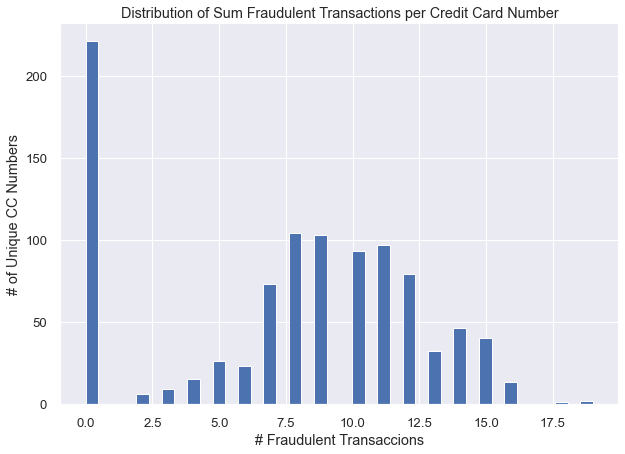

In [10]:
df.groupby('cc_num')['is_fraud'].sum().to_frame().hist(bins=40, figsize=(10,7))
plt.title('Sum of Fraudulent Transactions per Credit Card Number')
plt.xlabel('# Fraudulent Transactions')
plt.ylabel('# of Unique CC Numbers')
utils_payu.save_plot('fraud_per_cc');

También se presenta la exploración de la distribución geográfica de los fraudes, donde se puede ver una concentración en la costa este de Estados Unidos de estos casos. 

In [11]:
geometry = gpd.points_from_xy(df[df['is_fraud']==1].long, df[df['is_fraud']==1].lat)
df_geo = gpd.GeoDataFrame(df[df['is_fraud']==1], geometry = geometry)

Figure us_fraud_map saved!


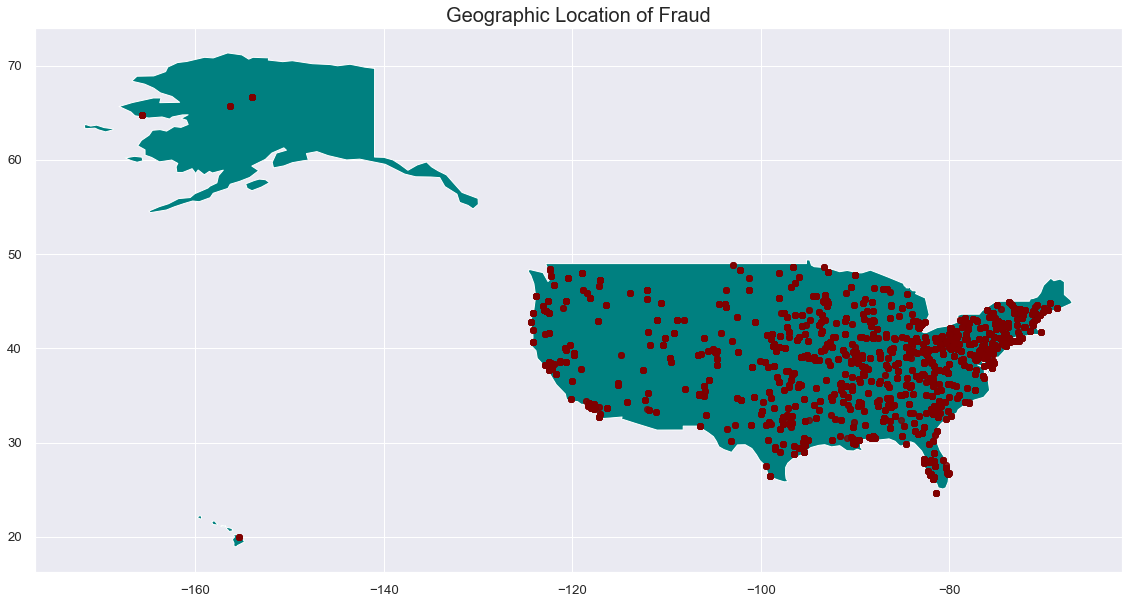

In [12]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
axis = world_data[world_data.name=='United States of America'].plot(
    figsize = (20,10),
    color = 'teal'
)
df_geo.plot(ax=axis, color='maroon', alpha=0.5)
plt.title('Geographic Location of Fraud', fontsize=20)
utils_payu.save_plot('us_fraud_map');

#### *Correlación lineal*
Finalmente, se presenta la correlación de las variables predictivas continuas y la variable objetivo, donde se evidencia una correlación relativamente alta de el monto de la transacción `amt` y la variable objetivo `is_fraud`. Además, cabe resaltar que la correlación del resto de variables es baja, por lo cual se parece que estas variables no son redundates o superfluas. 

Figure cont_vars_corr saved!


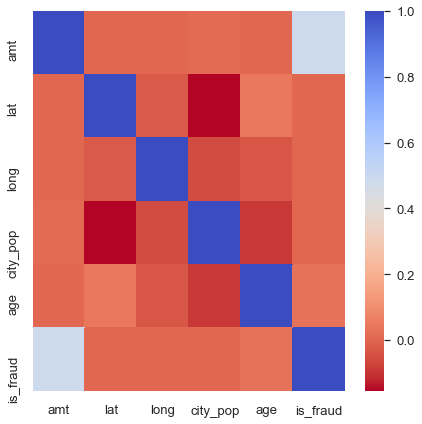

In [145]:
corr_matrix = df[cont_vars+['is_fraud']].corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corr_matrix, cmap='coolwarm_r', ax=ax)

utils_payu.save_plot('cont_vars_corr');

En cuanto a las variables de localización geográfica existe el par `lat, long` y `merch_lat, merch_long`. Al ver los valores de correlación se evidencia que estas se debe seleccionar un solo par, ya que tienen un nivel muy alto de correlación:

In [14]:
df[['lat','long','merch_lat','merch_long']].corr()

,lat,long,merch_lat,merch_long
lat,1.000000,-0.023602,0.993616,-0.023532
long,-0.023602,1.000000,-0.023531,0.999128
merch_lat,0.993616,-0.023531,1.000000,-0.023470
merch_long,-0.023532,0.999128,-0.023470,1.000000


# ***3. Preparación de Datos***
***

Dado que en el análisis inicial se vio que no hay datos faltantes, o problemas en los tipos de datos, ni datos atípicos o extremos, se la preparación de datos simplemente se compone de preparación de variables categóricas como *one-hot encoded vectors*.

Dado el modelo seleccionado (*i.e.* DNN), no se realizan transformaciones previas a las distribuciones de las variables, ya que de esto se encargarán las capas de `BatchNormalization` de la red neuronal, que aprende a normalizar y dar la mejor transformación de la distribución de las variables objetivo de forma que den el menor error posible.

Antes de hacer la separación *train/test* se crea una variable binaria nueva, que se llama `has_fraud`, donde se marca con 1 si ese el número de CC cometió fraude en el pasado, evaluando este componente temporal a través de la variable `trans_date_trans_time`, y 0 en caso de que ese número de tarjeta no haya cometido fraude. Esto sirve como una marca a esos números de tarjetas que se ha reconocido en el pasado que han cometido fraude, ya que como mostró el gráfico, las cuentas que generan transacciones fraudulentas suelen  hacerlo múltiples veces.

In [15]:
# Sort values by transaction date and CC number:
df.sort_values(by=['trans_date_trans_time','cc_num'])

# Mark CC number is in previous transactions it presented fraud:
for cc_num in df['cc_num'].unique():
    min_fraud = df.loc[
        (df['cc_num']==cc_num)&(df['is_fraud']==1), 
        'trans_date_trans_time'].min()
    if not isinstance(min_fraud, pd._libs.tslibs.nattype.NaTType):
        bool_mask_1 = (df['trans_date_trans_time']>min_fraud) & \
            (df['cc_num']==cc_num)
        bool_mask_2 = (df['trans_date_trans_time']<=min_fraud) & \
            (df['cc_num']==cc_num)
        df.loc[bool_mask_1, 'has_fraud'] = 1
        df.loc[bool_mask_2, 'has_fraud'] = 0
    else:
        df.loc[df['cc_num']==cc_num, 'has_fraud'] = 0
    

Abajo se puede ver un ejemplo donde la tarjeta presenta al inicio transacciones legítimas, y por lo tanto la variable `has_fraud` es 0. Un periodo después de que la primera transacción fraudulenta ocurre, la marca en `has_fraud` queda de ahí en adelante.

In [16]:
df[df['cc_num']==3524574586339330][['trans_date_trans_time','is_fraud','has_fraud']]

,trans_date_trans_time,is_fraud,has_fraud
184,2019-01-01 15:21:33,0,0.0
549,2019-01-03 07:03:22,0,0.0
1709,2019-01-07 18:52:20,0,0.0
5237,2019-01-20 18:19:39,0,0.0
5981,2019-01-22 20:47:30,0,0.0
...,...,...,...
196724,2020-06-11 19:49:54,0,0.0
198010,2020-06-14 23:30:42,0,0.0
200672,2020-06-21 00:07:09,1,0.0
200685,2020-06-21 01:00:08,1,1.0


Para la separación de los datasets de entrenamiento y evaluación, dado que estamos trabajando con un datos muy desbalanceados, se utiliza una partición estratificada con el fin de evitar sesgo en el muestreo. Con esto se garantiza que la proporción de casos de fraude en la base de entrenamiento sea similar a la proporción de transacciones fraudulentas en la base de evaluación, siendo este representativo de la población (cosa que no se garantiza con un muestreo aleatorio simple).

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Generate the stratified split object with 20% for testing:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1789)
for train_index, test_index in split.split(df, df['is_fraud']):
    strat_train_set_p = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
# Generate a validation dataset with 10% of the remaining data in the train data:
strat_train_set_p.reset_index(drop=True, inplace=True) 
split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1789)
for train_index, val_index in split_val.split(strat_train_set_p, 
                                              strat_train_set_p['is_fraud']):
    strat_train_set = strat_train_set_p.loc[train_index]
    strat_val_set = strat_train_set_p.loc[val_index]

In [18]:
train_pct = strat_train_set['is_fraud'].sum()/len(strat_train_set)*100
test_pct = strat_test_set['is_fraud'].sum()/len(strat_test_set)*100
val_pct = strat_val_set['is_fraud'].sum()/len(strat_val_set)*100
print(f'Fraud % train dataset = {train_pct:.2f}%')
print(f'Fraud % test dataset = {test_pct:.2f}%')
print(f'Fraud % validation dataset = {val_pct:.2f}%')

Fraud % train dataset = 3.74%
Fraud % test dataset = 3.74%
Fraud % validation dataset = 3.74%


Finalmente, para a selección de variables predictivas, se seleccionan:

+ `category`: *one-hot encoded* 
+ `amt`
+ `gender`: *one-hot encoded*
+ `city`: *one-hot encoded*
+ `state`: *one-hot encoded*
+ `zip`
+ `lat, long`
+ `age`: obtenida de la variable `dob`
+ `unix_time`
+ `has_fraud`: variable creada para marcar tarjetas que en el pasado presentaron transacciones fraudulentas

Se seleccionan todas estas variables categóricas dada la muy baja correlación de las variables numéricas vista durante la fase de exploración y análisis de los datos. Por lo cual, incluir todas estas variables puede aportar a dar mejor información para el modelo. Para evitar el peligro de llenar de basura el modelo, durante la fase de entrenamiento se utilizarán métodos de regularización ($l_1, l_2$) que castigan las variables que no aportan mucho al modelo.

Las variables categóricas se convierten en vectores binarios por medio del proceso de *one-hot encoding*. Esto se hace por medio de los objetos que se pueden encontrar en el modulo que diseñé `utils_payu`. Además, para los datos de entrenamiento se utiliza un método de *over-sampling* de la categoría de la variable objetivo que esta menos representada (que en este caso es fraude, como se mostró durante el análisis de datos).

In [101]:
cat_names = ['category', 'gender', 'state']
num_names = ['amt', 'zip', 'age', 'unix_time', 'has_fraud']
target_name = 'is_fraud'
prepared_data = utils_payu.PreparedData(
    cat_names = cat_names,
    num_names = num_names,
    target_names = target_name
)
x_train, y_train = prepared_data.prepare_data(strat_train_set)

x_test, y_test = prepared_data.prepare_data(strat_test_set, False, False)
x_val, y_val = prepared_data.prepare_data(strat_val_set, False, False)

Como se puede ver abajo ahora la categoría de fraude está mejor representada en la base de entrenamiento:

In [102]:
pct = (y_train==1).sum()/y_train.shape[0]
print(f'Percentage of fraud in traning dataset = {pct*100:.2f}%')

Percentage of fraud in traning dataset = 50.00%


In [103]:
pct = (y_test==1).sum()/y_test.shape[0]
print(f'Percentage of fraud in test dataset = {pct*100:.2f}%')

Percentage of fraud in test dataset = 3.74%


In [104]:
pct = (y_val==1).sum()/y_val.shape[0]
print(f'Percentage of fraud in validation dataset = {pct*100:.2f}%')

Percentage of fraud in validation dataset = 3.74%


# ***4. Selección del modelo***
***
En esta etapa se hace la selección del modelo a utilizar. Dada la baja correlación entre variables numéricas el la variable objetivo, y la cantidad de variables categóricas utilizadas, además de la necesidad de regularización y transformación de las distribuciones, se utiliza una red neuronal profunda como modelo base a entrenar y evaluar. 

Para esto se utiliza `TensorFlow`, y técnicas de *cross-validation* para finalmente seleccionar y ajustar el mejor modelo (dentro de lo razonable, dadas las restricciones de procesamiento y tiempo).

In [105]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Input, InputLayer
from tensorflow.keras import regularizers
import keras_tuner as kt
from functools import partial
import tensorflow_addons as tfa
import tensorflow as tf
from keras_tuner.engine.hyperparameters import HyperParameters

In [106]:
print(x_train.shape, x_test.shape, x_val.shape)

(278458, 72) (40177, 72) (16071, 72)


In [107]:
print(y_train.shape, y_test.shape, y_val.shape)

(278458, 1) (40177, 1) (16071, 1)


En la función `build_rnn_model` se define la función de generación del modelo. Además, dentro de esta función se colocan las posibles opciones de hiper-parámetros (HP) que se explorarán durante la fase de entrenamiento y mejora del modelo. 

Dada la gran cantidad de combinaciones posibles, el tamaño de la base de entrenamiento y los posibles niveles de complejidad que se pueden alcanzar, se utiliza una búsqueda aleatoria sobre el espacio de HP (considerando las limitaciones de tiempo, y poder computacional).Para hacer esto se utiliza de la librería `keras_tuner` el objeto `RandomSearch`, que realiza combinaciones aleatorias dentro del espacio de hiper-parámetros (HP). El criterio de selección del modelo es a partir del promedio de la precisión sobre la base de validación tras tres entrenamientos bajo cada combinación de HP. 

Para evitar *over-fitting* se utiliza un *callback* que para el entrenamiento del modelo si después de 10 epocas la métrica de la función de pérdida para la base de validación no presenta alguna mejora. Para esto se utiliza `EarlyStopping`

In [110]:
def build_rnn_model(hp):
    # Input layer:
    input_layer = Input(shape=x_train.shape[1:], name='Input_layer')

    # Define the search ranges:
    dense_units = hp.Choice('hidden_dnn_units', [128, 256, 512, 1024, 2048])
    batch_norm = hp.Boolean(name='BatchNormalization', default=True)
    dense_layers = hp.Int('dense_layers', 1, 10)
    optimizer = hp.Choice('optimizer', ['adam','nadam', 'rmsprop'])
    l1_reg = hp.Choice('l1_reg', [0.,0.01,0.1,0.2,0.3,0.4])
    
    # Create model according to chosen hyper-parameters:
    Elu_He = partial(
        Dense,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        kernel_regularizer = tf.keras.regularizers.L1(l1_reg)
    )
    h = BatchNormalization(name='BatchNorm1')(input_layer)
    for d_layer in range(dense_layers):
        name = f'Dense_{str(d_layer)}'
        h = Elu_He(dense_units, name=name)(h)
        if batch_norm:
            h = BatchNormalization()(h)
    output = Dense(1, activation='sigmoid', name='Output_layer')(h)
    
    # Define metrics:
    metrics = ['accuracy', tf.keras.metrics.AUC()]
    
    # Define model instance:
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = optimizer,
        metrics = metrics
    )
    return model
    

In [111]:
tuner = kt.RandomSearch(
    build_rnn_model,
    objective = 'val_accuracy',
    max_trials = 20,
    executions_per_trial = 3,
    project_name = 'PayU_classifier'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights = True
)
tuner.search(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_val, y_val),
    callbacks = [early_stopping]
)

Trial 20 Complete [00h 58m 41s]
val_accuracy: 0.988965630531311

Best val_accuracy So Far: 0.9896708329518636
Total elapsed time: 04h 42m 52s
INFO:tensorflow:Oracle triggered exit


El modelo tardó en entrenarse alrededor de 30 horas, donde se utilizó una GPU Nvidia GeForce GTX 1060 para acelerar el proceso.

### *Mejores HP*

In [130]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""The randomized hyperparameter search is over. 
    - Number of hidden units = {best_hps.get('hidden_dnn_units')}
    - Has batch normalization = {best_hps.get('BatchNormalization')}
    - Number of dense layers = {best_hps.get('dense_layers')}
    - L1 regularization term = {best_hps.get('l1_reg')}
    - Optimizer = {best_hps.get('optimizer')}""")

The randomized hyperparameter search is over. 
    - Number of hidden units = 256
    - Has batch normalization = True
    - Number of dense layers = 5
    - L1 regularization term = 0.0
    - Optimizer = adam


### *Arquitectura del Modelo*

In [127]:
final_model = tuner.get_best_models()[0]
#tf.keras.utils.plot_model(final_model,'i\\final_model.png',True)
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 72)]              0         
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 72)                288       
_________________________________________________________________
Dense_0 (Dense)              (None, 256)               18688     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792 

Finalmente, el modelo se guarda en la carpeta `Models`, bajo el nombre `final_model.h5`. Este se carga para probar que funciona adecuadamente. Como precaución, también se guardan los pesos encontrados, de forma que si ocurre algún problema a la hora de cargar el modelo guardado, se pueda construir la arquitectura y simplemente colocar los pesos de los parámetros entrenados.

In [139]:
final_model.save('Models\\final_model.h5')
final_model.save_weights('Models\\final_model_weights.h5')

In [119]:
test_model = tf.keras.models.load_model('Models\\final_model.h5')

# 5. ***Presentación de Resultados***
***
En esta sección se presentan los resultados del modelo para las tres bases (*i.e. train, validation, test*), haciendo énfasis en los resultados sobre la base de evaluación (*test*). Antes de empezar ver esto cabe la pena resaltar que, dado que estamos trabajando con una base desbalanceada, donde la clase de interés solo aparece el 3.74% de los casos, la métrica de *accuracy* puede resultar engañozamente buena. Por lo tanto, si en todos los casos se selecciona 0 (no fraude) se tendría un resultado en *accuracy* de 96.26%. Por esta razón se utilizan otras métricas complementarias para evaluar el rendimiento del modelo de forma más balanceada para las dos clases.

Primero, abajo se pueden ver los resultados para las tres diferentes bases utilizadas. Es destacable que a pesar de la complejidad relativa y que el no se coloca regularización $l_1$ (como se puede ver en la selección de HP) no parece haber *over-fitting*. Además se ven muy buenos resultados para las tres bases!

In [121]:
train_metrics = test_model.evaluate(x_train, y_train)
validation_metrics = test_model.evaluate(x_val, y_val)
test_metrics = test_model.evaluate(x_test, y_test)

1256/1256 [==============================] - 3s 2ms/step - loss: 0.0397 - accuracy: 0.9892 - auc: 0.9757


In [123]:
print(f"""
Train results: 
--------------
Binary cross-entropy loss = {train_metrics[0]:.4f}
Accuracy loss = {train_metrics[1]*100:.4f}%
Area Under the Curve (AUC) = {train_metrics[2]*100:.4f}%""")


Train results: 
--------------
Binary cross-entropy loss = 0.0568
Accuracy loss = 98.1606%
Area Under the Curve (AUC) = 99.8355%


In [124]:
print(f"""
Validation results: 
--------------
Binary cross-entropy loss = {validation_metrics[0]:.4f}
Accuracy loss = {validation_metrics[1]*100:.4f}%
Area Under the Curve (AUC) = {validation_metrics[2]*100:.4f}%""")


Validation results: 
--------------
Binary cross-entropy loss = 0.0382
Accuracy loss = 99.0480%
Area Under the Curve (AUC) = 97.8275%


In [125]:
print(f"""
Test results: 
--------------
Binary cross-entropy loss = {test_metrics[0]:.4f}
Accuracy loss = {test_metrics[1]*100:.4f}%
Area Under the Curve (AUC) = {test_metrics[2]*100:.4f}%""")


Test results: 
--------------
Binary cross-entropy loss = 0.0397
Accuracy loss = 98.9198%
Area Under the Curve (AUC) = 97.5730%


Al revisar métricas complementarias sobre los resultados sobre la base de evaluación, se ve que los resultados sobre ambas clases es bastante bueno, a pesar de el desbalance en las clases de la variable objetivo. Por esto, se puede concluir que el modelo presentado parece tener un muy buen rendimiento para la tarea en cuestión. 

In [138]:
from sklearn.metrics import classification_report
y_hat_test = test_model.predict(x_test)
print(classification_report(y_test, (y_hat_test>=0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38676
           1       0.91      0.79      0.85      1501

    accuracy                           0.99     40177
   macro avg       0.95      0.89      0.92     40177
weighted avg       0.99      0.99      0.99     40177

